In [57]:
# biosignalsnotebooks own package.
import biosignalsnotebooks as bsnb

# Scientific programming package.
from numpy import average, array, reshape, sqrt, sort, diff, where, argmax, max
from numbers import Number

# Pacakge dedicated to Wavelet decomposition algorithms.
from pywt import swt, iswt

# Machine-learning dedicated package.
from sklearn.mixture import GaussianMixture

# Gaussian Distribution function.
from scipy.stats import norm

# Built-in packages.
from copy import deepcopy
import numpy as np

In [245]:
folder_name = 'Zeyu'
file_name = 'Zeyu_7_music.txt'

In [246]:
# Load entire acquisition data.
data, header = bsnb.load(f"{folder_name}/{file_name}", get_header=True)


In [247]:
# EDA
signal = data["CH1"]

# Sampling rate definition.
sr = header["sampling rate"]

# Raw to uS sample value conversion.
signal_us = bsnb.raw_to_phy("EDA", "bitalino_rev", signal, 10, "uS")

In [248]:
print(signal_us.shape[0])

246900


In [249]:
target_len = 262144
if signal_us.shape[0] < target_len:
    padding = np.tile(signal_us[-1], (target_len - signal_us.shape[0], 1))
    signal_us = np.hstack((signal_us, padding.flatten()))
else:
    signal_us = signal_us[:target_len]

In [250]:

fs = 1000
time = bsnb.generate_time(signal_us, fs)
time = np.array(time)

In [251]:
import matplotlib.pyplot as plt
def graph_eda(Sig, time):
    fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

    # Plot accelerometer data
    axs.plot(time, Sig)
    axs.set_ylabel('X Axis')
    axs.grid(True)
    # Set title for the entire plot
    plt.suptitle('EDA Data')

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()


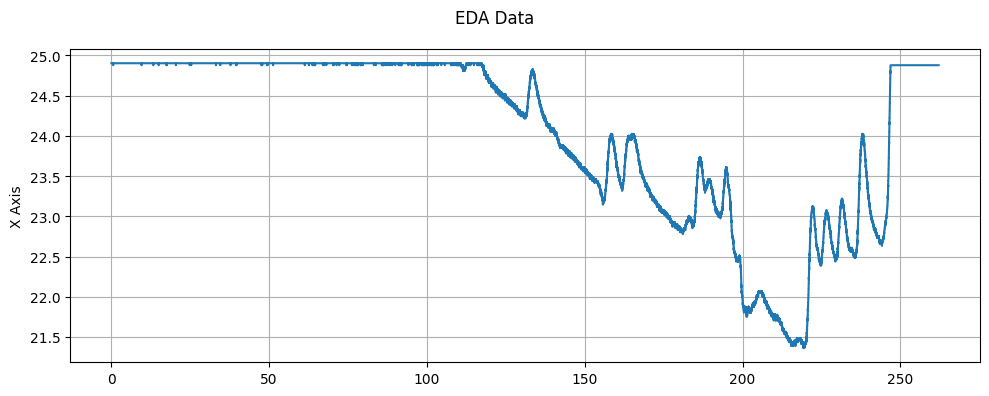

In [252]:
graph_eda(signal_us, time)

In [253]:
# Conventional 1st order Butterworth bandpass filtering 
# (due to the restrictive bandwidth in order to guarantee system stability it is necessary to reduce the filter order)
# [Option RES]
signal_res = bsnb.bandpass(signal_us, 0.045, 0.25, order=1, fs=sr, use_filtfilt=True)

# Conventional 2nd order Butterworth lowpass filtering 
# [Option EXT]
signal_ext = bsnb.lowpass(signal_us, 35, order=2, fs=sr, use_filtfilt=True)

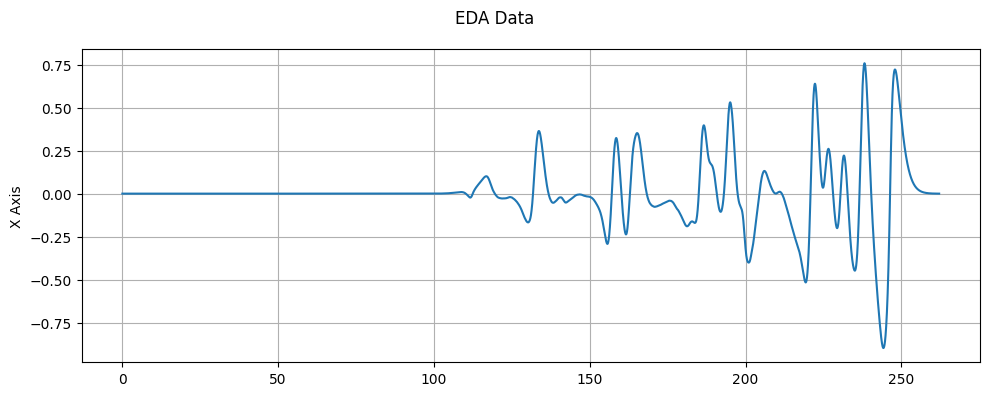

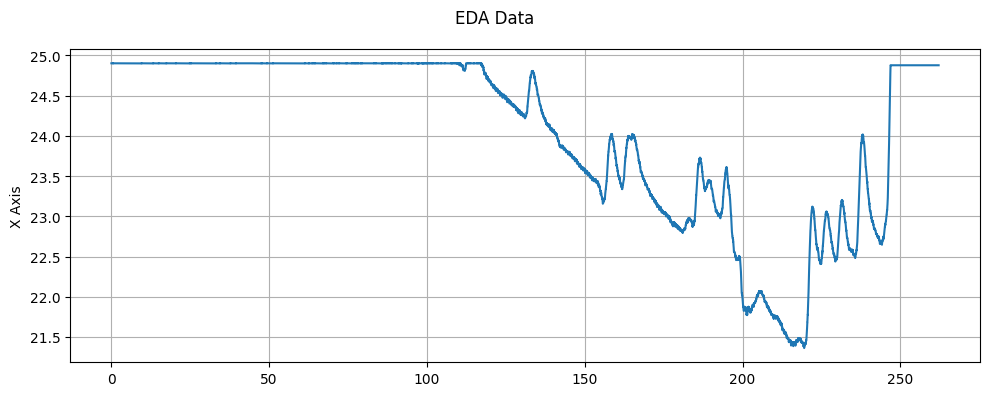

In [254]:
graph_eda(signal_res, time)
graph_eda(signal_ext, time)

In [255]:
print(signal_ext.shape)

(262144,)


In [256]:
# SWT 8th level Decomposition using "Haar" mother wavelet (taking into consideration its ability to detect "edges" in the signal) .
swt_orig_coeffs = swt(signal_ext, "haar", level=12)

# Restriction of filtering algorithm to the coefficients of the last decomposition level.
detail_coeffs = swt_orig_coeffs[0][1]
scaling_coeffs = swt_orig_coeffs[0][0]

In [257]:
print(detail_coeffs, scaling_coeffs)

[-0.00038147 -0.00038147 -0.00038147 ... -0.00152588 -0.00114441
 -0.00076294] [1593.74961853 1593.74961853 1593.74961853 ... 1593.74847412 1593.74885559
 1593.74923706]


In [258]:
gaussian_mixt = GaussianMixture(n_components=2, covariance_type="spherical") # "spherical" covariance type ensures that each Gaussian components has its own single variance.

# Reshape data to a column vector format.
detail_coeffs_col = reshape(detail_coeffs, (len(detail_coeffs), 1))

# Fit data to our model object.
gaussian_mixt.fit(detail_coeffs_col)

GaussianMixture(covariance_type='spherical', n_components=2)

In [259]:
# Normal distribution function objects.
norm_1 = norm(loc=gaussian_mixt.means_[0][0], scale=sqrt(gaussian_mixt.covariances_[0])) 
norm_2 = norm(loc=gaussian_mixt.means_[1][0], scale=sqrt(gaussian_mixt.covariances_[1])) 

# Component weights.
weight_1 = gaussian_mixt.weights_[0]
weight_2 = gaussian_mixt.weights_[1]

# CDF values for the coefficients under analysis.
sort_detail_coeffs = sort(detail_coeffs)
norm_1_cdf = norm_1.cdf(sort_detail_coeffs)
norm_2_cdf = norm_2.cdf(sort_detail_coeffs)

# CDF of the Gaussian mixture.
cdf_mixt = weight_1 * norm_1_cdf + weight_2 * norm_2_cdf


In [260]:
art_prop = 0.01 # Artifact proportion value.
low_thr = None 
high_thr = None

# Check when the CDF mixture function reaches values art_prop / 2 and 1 - art_prop / 2.
for i in range(0, len(norm_1_cdf)):
    # Low threshold clause.
    if cdf_mixt[i] - cdf_mixt[0] >= art_prop and low_thr == None:
        low_thr = sort_detail_coeffs[i]
        
    # High threshold clause.
    if cdf_mixt[-1] - cdf_mixt[i] <= art_prop and high_thr == None:
        high_thr = sort_detail_coeffs[i]

In [261]:
filt_detail_coeffs = deepcopy(detail_coeffs)
count_1 = 0
count_2 = 0
for j in range(0, len(filt_detail_coeffs)):
    if detail_coeffs[j] <= low_thr or detail_coeffs[j] >= high_thr:
        filt_detail_coeffs[j] = 0
    else:
        continue
        
# Update of the SWT decomposition tupple.
swt_coeffs = [(array(scaling_coeffs), array(filt_detail_coeffs))]

In [262]:
rec_signal = iswt(swt_coeffs, "haar")

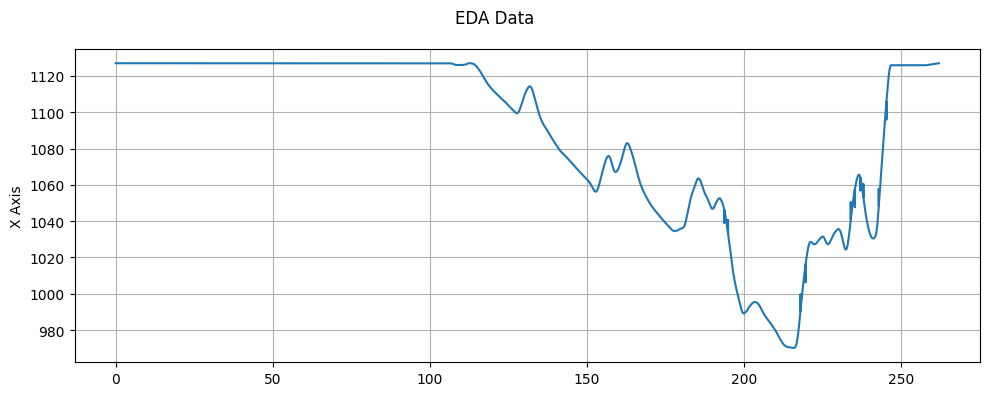

In [263]:
graph_eda(rec_signal, time)

In [264]:
signal_int = bsnb.smooth(rec_signal, sr * 3) # Moving average witt window size equal to 3 x sampling rate.

# Rescale signal.
signal_int = signal_int * (max(signal_ext) / max(signal_int))

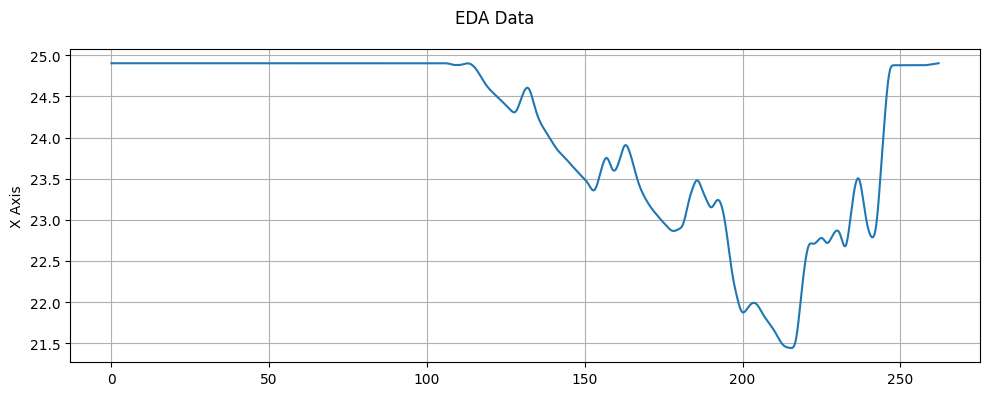

In [265]:
graph_eda(signal_int, np.array(bsnb.generate_time(signal_int, fs)))

In [266]:
print(signal_int)

[24.903084   24.903084   24.90308401 ... 24.90306314 24.9030691
 24.90307506]
